In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

import seaborn as sns

from sklearn.datasets import make_classification

from bertopic import BERTopic

import torch
from torch import nn
import torch.nn.functional as F

In [85]:
# load the data

PUBMED_PATH = Path('data/pubmed_abstracts_preprocessed.csv.gz')
MODEL_NAME = 'pubmed1pct_bertopic'
VERSION = 'v202109291'

indices = np.load(f'outputs/models/{MODEL_NAME}_{VERSION}.idx.npz')['arr_0']
model: BERTopic = BERTopic.load(f'outputs/models/{MODEL_NAME}_{VERSION}.model')
topics = np.load(f'outputs/models/{MODEL_NAME}_{VERSION}.topics.npz')['arr_0']
probs = np.load(f'outputs/models/{MODEL_NAME}_{VERSION}.probs.npz')['arr_0']

PUBMED = pd.read_csv(PUBMED_PATH)
PUBMED = PUBMED[PUBMED.index.isin(indices)]
PUBMED['label'] = PUBMED['subcategory'].astype('category')

100%|██████████| 2000/2000 [00:05<00:00, 397.56it/s]


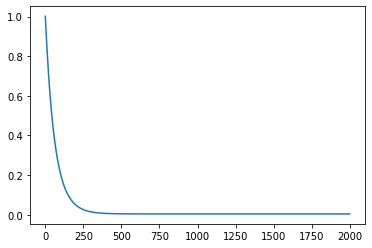

In [90]:
from tqdm import tqdm
import matplotlib.pyplot as plt

batch_size = 200

# n_topics = 300
# n_samples = 1000
# n_labels = 10
# X, y = make_classification(n_samples=n_samples, n_features=n_topics, n_classes=n_labels, n_informative=10, random_state=0)

X = probs
y = PUBMED['label'].cat.codes.values
n_topics = X.shape[1]
n_samples = X.shape[0]
n_labels = y.max() + 1

X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.long)

model = nn.Embedding(n_labels, n_topics)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trace = []

for epoch in tqdm(range(2000)):
  model.train()
  model.zero_grad()
  X_pred = model(y)
  loss = criterion(X, X_pred)
  trace.append(loss.detach().item())
  loss.backward()
  optimizer.step()

plt.plot(trace)
plt.show()

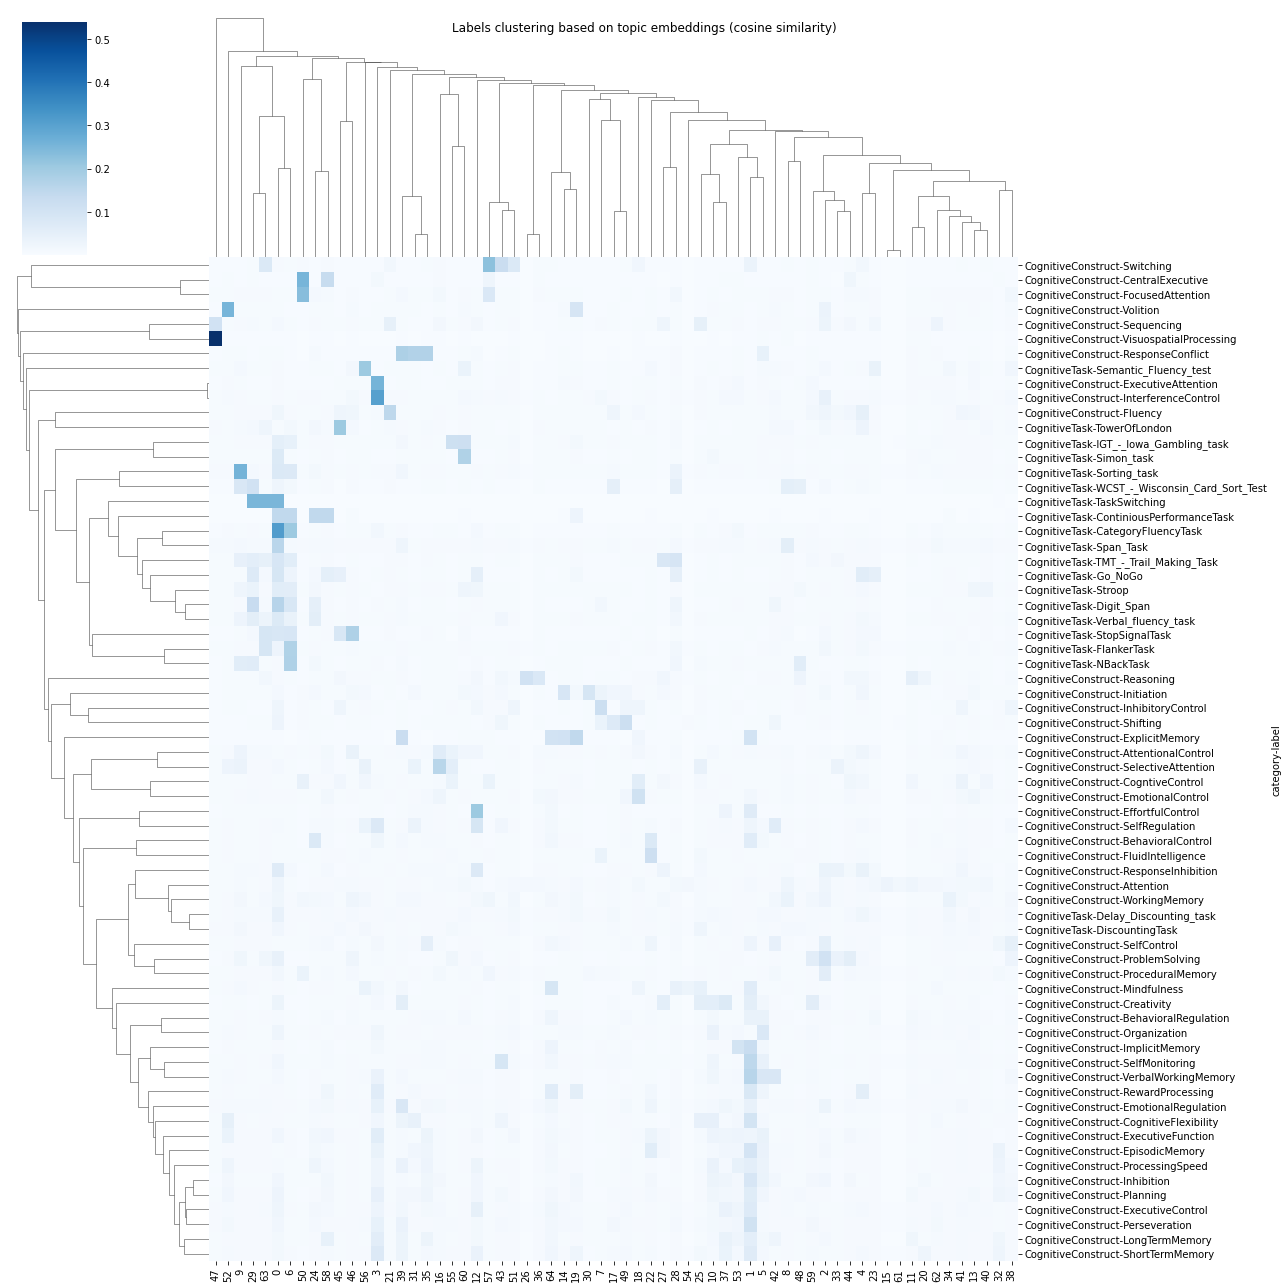

In [204]:

# convert to a dataframe, indexed by label and category
H = pd.DataFrame(next(model.parameters()).detach().numpy())
labels = PUBMED['label'].cat.categories[H.index]
categories = labels.to_series().apply(lambda lbl: PUBMED.query('label == @lbl')['category'].unique().item())
indices = categories.to_frame().reset_index().rename(columns={0: 'category', 'index': 'label'})
H.index = pd.MultiIndex.from_frame(indices).reorder_levels(['category', 'label'])

sns.clustermap(H, metric='cosine', figsize=(18, 18), cmap='Blues')
plt.suptitle('Labels clustering based on topic embeddings (cosine similarity)')
# plt.tight_layout()
plt.show()

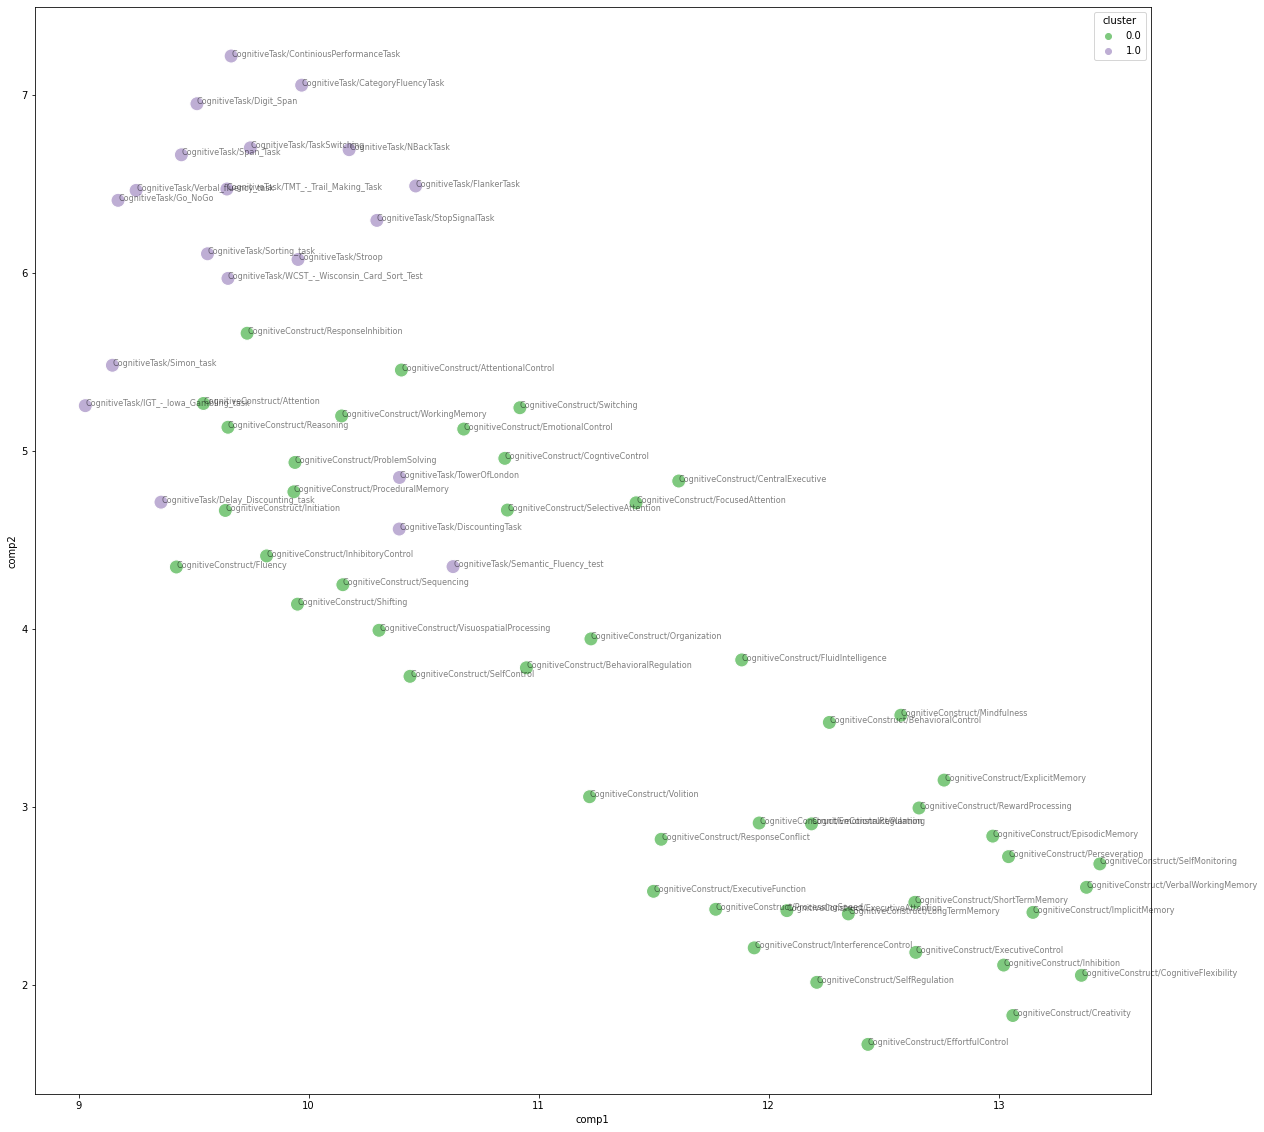

In [297]:
import hdbscan
import umap
from sklearn.decomposition import PCA


H_projection = umap.UMAP(n_components=2, random_state=0).fit_transform(H)
# H_projection = PCA(n_components=2, random_state=0).fit_transform(H)

# clusters = hdbscan.HDBSCAN(3).fit_predict(H).reshape(-1,1)
clusters = hdbscan.HDBSCAN().fit_predict(H_projection).reshape(-1,1)
clusters = H.index.to_frame()['category'].astype('category').cat.codes.values.reshape(-1,1)

H_projection = np.hstack((H_projection, clusters))

fig, ax = plt.subplots(1,1, figsize=(20,20))

sns.scatterplot(
    data=pd.DataFrame(H_projection, columns=['comp1', 'comp2', 'cluster']),
    x='comp1', y='comp2', hue='cluster', ax=ax, palette='Accent', s=200)

for (cat, lbl), (x, y, c) in zip(H.index.to_list(), H_projection):
    ax.text(x, y, f'{cat}/{lbl}', alpha=0.5, fontsize=8)

plt.show()
